# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np
import torch.nn as nn

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

# Preparing Training and Test Sets

In [2]:
from distutils.dir_util import copy_tree


directory = './data/COVID-19_Radiography_Dataset'

source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID','Lung_Opacity']
input_dir = './train'
output_dir = './test'
root_dir = './train/COVID-19_Radiography_Dataset'



if os.path.isdir(os.path.join(directory, source_dirs[1])):
    if not os.path.isdir(input_dir):
        os.mkdir(input_dir)
        copy_tree(directory, input_dir)
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
        
    for c in source_dirs:
        if not os.path.isdir(os.path.join(output_dir, c)):
            os.mkdir(os.path.join(output_dir, c))
            
    for c in source_dirs:
        images = [x for x in os.listdir(os.path.join(input_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(input_dir, c, image)
            target_path = os.path.join(output_dir, c, image)
            shutil.move(source_path, target_path)


# Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['Normal', 'Viral', 'COVID-19','Lung_Opacity']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [4]:
# All pre-trained models expect input images normalized in the same way,
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
# where H and W are expected to be at least 224. 
# The images have to be loaded in to a range of [0, 1] and then normalized using 
# mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

#Creating a Transformation Object
train_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(), #A RandomHorizontalFlip to augment our data
    torchvision.transforms.ToTensor(), #Converting to tensor    
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])

In [5]:
#Creating a Transformation Object
test_transform = torchvision.transforms.Compose([
    #Converting images to the size that the model expects
    torchvision.transforms.Resize(size=(224,224)),
# We don't do data augmentation in the test/val set    
    torchvision.transforms.ToTensor(), #Converting to tensor
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225]) #Normalizing the data to the data that the ResNet18 was trained on
    
])

# Prepare DataLoader


In [6]:
train_dirs = {
    'Normal': input_dir + '/NORMAL',
    'Viral': input_dir + '/Viral Pneumonia',
    'COVID-19': input_dir + '/COVID',
    'Lung_Opacity': input_dir + '/Lung_Opacity'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 9472 Normal examples
Found 625 Viral examples
Found 2896 COVID-19 examples
Found 5382 Lung_Opacity examples


In [7]:
test_dirs = {
    'Normal': output_dir + '/NORMAL',
    'Viral': output_dir + '/Viral Pneumonia',    
    'COVID-19': output_dir + '/COVID',
    'Lung_Opacity': output_dir + '/Lung_Opacity',
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 720 Normal examples
Found 720 Viral examples
Found 720 COVID-19 examples
Found 630 Lung_Opacity examples


In [8]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 3063
Num of test batches 465


# Data Visualization

In [13]:
class_names = train_dataset.class_names

def show_images(images,labels, preds):
    plt.figure(figsize=(8,4))
    
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks =[]) # x & y ticks are set to blank
        image = image.numpy().transpose((1, 2, 0)) # Channel first then height and width
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

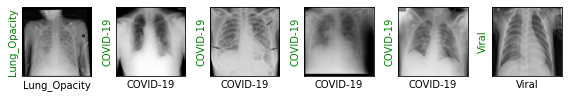

In [10]:
images, labels = next(iter(dl_train)) #Fetch the next batch of images
show_images(images, labels, labels)

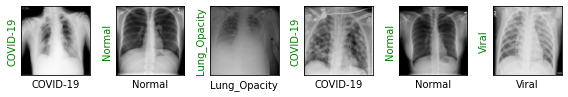

In [11]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [12]:
# #for resnet
model = torchvision.models.resnet18(pretrained=True) #resnet18 is a small CNN that we can train quickly giving us decent results
# #Changing the last fc to 4 output features
model.fc = torch.nn.Linear(in_features=512, out_features=4)

In [13]:
# for densenet
# model = torchvision.models.densenet121(pretrained=True)
# #Changing the last fc to 4 output features
# model.classifier = nn.Linear(in_features=1024, out_features=4)

In [14]:

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5) #To find optimum learning rate 1. Trial/Error 2. Hyperparameter search

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)

model.to(device)

Let's use 2 GPUs!


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [11]:
def show_preds():
    model.eval()  #Setting the model to evaluation mode
    images, labels = next(iter(dl_test))
    outputs = model(images)
    if torch.cuda.device_count() > 1:
        outputs = outputs.cpu() 
    _, preds = torch.max(outputs, 1)
    #print(images)
    #print(labels)
    #print(preds)
    show_images(images, labels, preds)

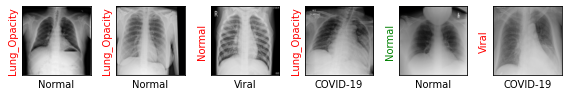

In [17]:
show_preds()

# Training the Model

In [18]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.  #Not computing val_loss since we'll be evaluating the model multiple times within one epoch
        
        model.train() # set model to training phase
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            if torch.cuda.device_count() > 1:
                outputs = model(images.to(device))
                labels = labels.to(device)
            else:                
                outputs = model(images)
            loss = loss_fn(outputs, labels)
            #Once we get the loss we need to take a gradient step
            loss.backward() #Back propogation
            optimizer.step() #Completes the gradient step by updating all the parameter values(We are using all parameters)
            train_loss += loss.item() #Loss is a tensor which can't be added to train_loss so .item() converts it to float
            
            #Evaluating the model every 20th step
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                model.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = model(images)
                    if torch.cuda.device_count() > 1:
                        outputs = outputs.cpu() 
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1) # 1 corresponds to the values and ) corresponds to the no of examples
                    accuracy += sum((preds == labels).numpy()) #adding correct preds to acc

                val_loss /= (val_step + 1) # 15 test batches so this logic gives the value for each step
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()
                model.train()

                if accuracy >= 0.80:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')


Starting training..
Starting epoch 1/1
Evaluating at step 0


c:\users\dhiman\anaconda3\envs\dlh\lib\site-packages\torch\cuda\nccl.py:14: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Validation Loss: 1.4189, Accuracy: 0.2049


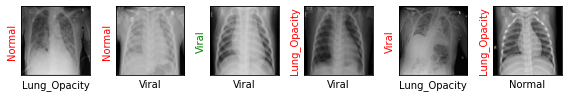

Evaluating at step 20
Validation Loss: 1.0990, Accuracy: 0.5266


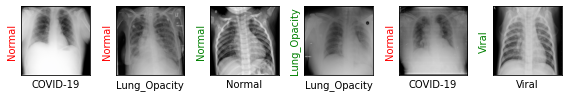

Evaluating at step 40
Validation Loss: 0.8564, Accuracy: 0.7030


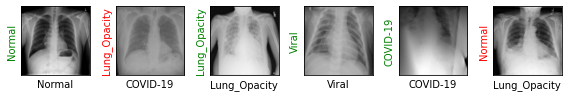

Evaluating at step 60
Validation Loss: 0.6718, Accuracy: 0.7479


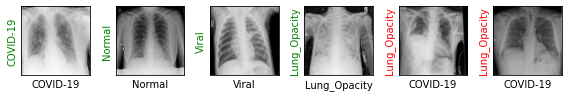

Evaluating at step 80
Validation Loss: 0.5909, Accuracy: 0.7783


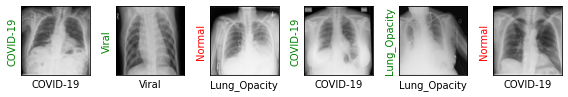

Evaluating at step 100
Validation Loss: 0.5864, Accuracy: 0.7918


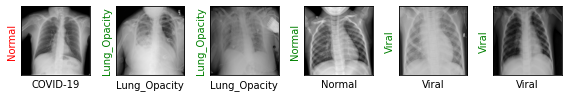

Evaluating at step 120
Validation Loss: 0.5442, Accuracy: 0.7963


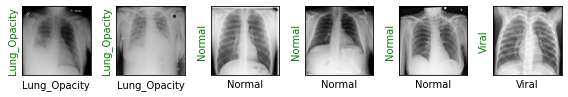

Evaluating at step 140
Validation Loss: 0.4932, Accuracy: 0.8348


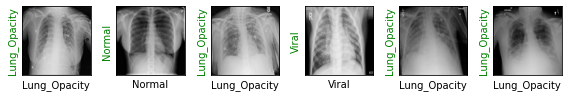

Performance condition satisfied, stopping..
Wall time: 2min 49s


In [19]:
%%time

train(epochs=1)

In [21]:
torch.save(model,'model.pt')


In [9]:
model = torch.load("model.pt") 
# Its tested and working. only need to run cells before 
#"Creating the Model" section and def show_pred method.

# Final Results

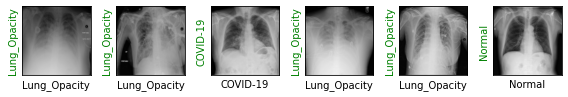

In [14]:
show_preds()